In [20]:
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from numpy import log
import time
from keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from keras.layers import Dense, LeakyReLU
from keras.activations import elu
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import LeakyReLU, ELU
# from arch import arch_model
from sklearn.preprocessing import StandardScaler
from keras.layers import GRU, Dense, Dropout
#importing necessary libraries
from math import log, exp
from datetime import datetime
from numpy import log, exp


In [21]:
class EuropeanOptionBS:
    def __init__(self, S, K, T, r, q, sigma, Type):
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.Type = Type
        self.d1 = self.d1()
        self.d2 = self.d2()
        self.price = self.price()

    def d1(self):
        d1 = (math.log(self.S / self.K) +
              (self.r - self.q + 0.5 * (self.sigma ** 2)) * self.T) / \
             (self.sigma * math.sqrt(self.T))
        return d1

    def d2(self):
        d2 = self.d1 - self.sigma * math.sqrt(self.T)
        return d2

    def price(self):
        if self.Type == "Call":
            price = self.S * math.exp(-self.q * self.T) * norm.cdf(self.d1) - \
                    self.K * math.exp(-self.r * self.T) * norm.cdf(self.d2)
        if self.Type == "Put":
            price = self.K * math.exp(-self.r * self.T) * norm.cdf(-self.d2) - \
                    self.S * math.exp(-self.q * self.T) * norm.cdf(-self.d1)
        return price

# real data

In [22]:


# Function to process AAPL CSV data (adapted from original data_cleaning function)
def data_cleaning_aapl(df_subset, maturity_date):
    """
    Clean and process AAPL options data subset.
    Adapted from original data_cleaning() function to work with AAPL CSV format.
    Follows exact same logic as original notebook.
    """
    df = df_subset.copy()
    
    # Step 1: Ensure column names are clean (already done in loading, but ensure)
    df.columns = df.columns.str.strip().str.replace('[', '').str.replace(']', '')
    
    # Step 2: Rename columns to match expected format (same as original)
    # Original: {"Price~" : "underlying_stockprice", 'Last' : 'option_price'}
    columns = {
        "UNDERLYING_LAST": "underlying_stockprice",
        'C_LAST': 'option_price',
        'QUOTE_DATE': 'Time'
    }
    df.rename(columns=columns, inplace=True)
    
    # Step 3: Handle IV conversion (same as original)
    # Original: df[column_to_convert] = df[column_to_convert].str.rstrip('%').astype('float') / 100.0
    column_to_convert = 'C_IV'
    if column_to_convert in df.columns:
        # Remove rows with missing IV
        df = df[df[column_to_convert].notna()]
        df[column_to_convert] = df[column_to_convert].replace('', np.nan)
        df[column_to_convert] = pd.to_numeric(df[column_to_convert], errors='coerce')
        df = df[df[column_to_convert].notna()]
        df = df[df[column_to_convert] > 0]
        
        # Convert IV to decimal (same as original logic)
        if len(df) > 0 and df[column_to_convert].max() > 1:
            df[column_to_convert] = df[column_to_convert] / 100.0
        df.rename(columns={column_to_convert: 'IV'}, inplace=True)
    
    # Step 4: Convert Time to datetime (same as original: format='%m/%d/%Y')
    # AAPL format: '2022-07-01'
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    df = df[df['Time'].notna()]
    
    # Step 5: Convert numeric columns
    df['underlying_stockprice'] = pd.to_numeric(df['underlying_stockprice'], errors='coerce')
    df['option_price'] = pd.to_numeric(df['option_price'], errors='coerce')
    df['Strike'] = pd.to_numeric(df['STRIKE'], errors='coerce')
    df['Volume'] = pd.to_numeric(df['C_VOLUME'], errors='coerce')
    
    # Step 6: Drop unnecessary columns (same as original)
    for col in ['Open', 'High', 'Low', 'Change', '%Chg', 'Bid', 'Ask', 'Open Int', 'Delta', 
                'Gamma', 'Theta', 'Vega', 'Rho', 'Theo', 'STRIKE', 'C_VOLUME', 'QUOTE_DATE',
                'C_BID', 'C_ASK', 'P_BID', 'P_ASK', 'C_SIZE', 'P_SIZE']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    
    # Step 7: Sort by Time (same as original)
    df.sort_values(by='Time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Step 8: Basic filtering (same as original)
    df = df[df['underlying_stockprice'] > 0]
    r = 0.0516
    df['r'] = 0.0516
    
    # Step 9: Calculate Maturity (same as original: (maturity_date - df['Time']).dt.days / 252)
    df['Maturity'] = (maturity_date - df['Time']).dt.days 
    df['Maturity'] = df['Maturity'] / 252
    
    # Step 10: Feature Engineering (same as original)
    df['C/S'] = df['option_price'] / df['underlying_stockprice']
    df['Monyness'] = df['underlying_stockprice'] / df['Strike']
    df['K/S'] = df['Strike'] / df['underlying_stockprice']
    
    # Step 11: Data Filtering (same as original)
    df = df[df['Volume'] != 0]
    df = df[df['option_price'] != 0]
    df = df[df['option_price'] >= 0.1]
    df = df[df['Maturity'] <= 2.4]
    df = df[df['Maturity'] > 0]
    df = df.dropna()
    
    return df

In [23]:
# Load the AAPL CSV file (same as original notebook loads multiple CSVs)
print("Loading AAPL options data...")
df_raw = pd.read_csv('aapl_2021_2023.csv', low_memory=False)

# Strip brackets from column names
df_raw.columns = df_raw.columns.str.strip().str.replace('[', '').str.replace(']', '')

print(f"✓ Loaded {len(df_raw):,} rows")
print(f"✓ Date range: {df_raw['QUOTE_DATE'].min()} to {df_raw['QUOTE_DATE'].max()}")
print(f"✓ Columns: {len(df_raw.columns)}")

# Convert QUOTE_DATE to datetime for grouping
df_raw['QUOTE_DATE'] = pd.to_datetime(df_raw['QUOTE_DATE'], errors='coerce')
df_raw = df_raw[df_raw['QUOTE_DATE'].notna()]

# Group data by year-month (similar to original notebook's date groups)
# This mimics the original structure: 20240315, 20240419, 20240503, 20240517
df_raw['YearMonth'] = df_raw['QUOTE_DATE'].dt.to_period('M')

# Get unique year-months
unique_months = sorted(df_raw['YearMonth'].unique())
print(f"\n✓ Found {len(unique_months)} unique months")
print(f"✓ Sample months: {unique_months[:10]}")

# For 2022 data (as planned), filter to 2022
df_raw_2022 = df_raw[df_raw['QUOTE_DATE'].dt.year == 2022].copy()
unique_months_2022 = sorted(df_raw_2022['YearMonth'].unique())
print(f"\n✓ 2022 data: {len(df_raw_2022):,} rows across {len(unique_months_2022)} months")
print(f"✓ 2022 months: {unique_months_2022}")


Loading AAPL options data...
✓ Loaded 548,163 rows
✓ Date range:  2021-01-04 to  2023-03-31
✓ Columns: 33

✓ Found 27 unique months
✓ Sample months: [Period('2021-01', 'M'), Period('2021-02', 'M'), Period('2021-03', 'M'), Period('2021-04', 'M'), Period('2021-05', 'M'), Period('2021-06', 'M'), Period('2021-07', 'M'), Period('2021-08', 'M'), Period('2021-09', 'M'), Period('2021-10', 'M')]

✓ 2022 data: 236,004 rows across 12 months
✓ 2022 months: [Period('2022-01', 'M'), Period('2022-02', 'M'), Period('2022-03', 'M'), Period('2022-04', 'M'), Period('2022-05', 'M'), Period('2022-06', 'M'), Period('2022-07', 'M'), Period('2022-08', 'M'), Period('2022-09', 'M'), Period('2022-10', 'M'), Period('2022-11', 'M'), Period('2022-12', 'M')]


In [24]:
# Process data by month groups (similar to original notebook's date groups)
# We'll use the last day of each month as maturity_date (or use EXPIRE_DATE from data)

# Select a few representative months from 2022 for processing
# Similar to original: 4 date groups (20240315, 20240419, 20240503, 20240517)
selected_months = unique_months_2022[:4] if len(unique_months_2022) >= 4 else unique_months_2022

print(f"Processing {len(selected_months)} month groups:")
for month in selected_months:
    print(f"  - {month}")

# Dictionary to hold processed DataFrames (like original: processed_2024419, etc.)
processed_groups = {}


Processing 4 month groups:
  - 2022-01
  - 2022-02
  - 2022-03
  - 2022-04


In [25]:
# Process each month group (similar to original notebook's loop)
for month_period in selected_months:
    # Get data for this month
    month_data = df_raw_2022[df_raw_2022['YearMonth'] == month_period].copy()
    
    # Use the last day of the month as maturity_date (or could use max EXPIRE_DATE)
    # Convert Period to datetime for maturity_date calculation
    month_end = month_period.to_timestamp() + pd.offsets.MonthEnd(0)
    maturity_date = datetime(month_end.year, month_end.month, month_end.day)
    
    # Process this month's data
    print(f"\nProcessing {month_period} (maturity_date: {maturity_date.date()})...")
    processed_df = data_cleaning_aapl(month_data, maturity_date)
    
    # Store in dictionary (like original: processed_2024419[df_name])
    group_name = f"processed_{month_period.strftime('%Y%m')}"
    processed_groups[group_name] = processed_df
    
    print(f"  ✓ Processed {len(processed_df):,} rows")

print(f"\n✓ Total groups processed: {len(processed_groups)}")



Processing 2022-01 (maturity_date: 2022-01-31)...
  ✓ Processed 10,706 rows

Processing 2022-02 (maturity_date: 2022-02-28)...
  ✓ Processed 8,470 rows

Processing 2022-03 (maturity_date: 2022-03-31)...
  ✓ Processed 9,712 rows

Processing 2022-04 (maturity_date: 2022-04-30)...
  ✓ Processed 8,326 rows

✓ Total groups processed: 4


In [26]:
# Combine each group's DataFrames (similar to original: combined_df1, combined_df2, etc.)
# Since we have multiple groups, combine them similar to original notebook

combined_dfs = []
group_names = sorted(processed_groups.keys())

for i, group_name in enumerate(group_names, 1):
    if len(processed_groups[group_name]) > 0:
        combined_df = pd.concat([processed_groups[group_name]], ignore_index=True)
        combined_dfs.append(combined_df)
        print(f"combined_df{i} ({group_name}): {len(combined_df):,} rows")

# Final combination (like original: combined_df = pd.concat([combined_df1, combined_df2, combined_df3, combined_df4]))
if len(combined_dfs) > 0:
    combined_df = pd.concat(combined_dfs, ignore_index=True)
    print(f"\n✓ Final combined_df: {len(combined_df):,} rows")
    print(f"✓ Shape: {combined_df.shape}")
else:
    print("⚠ No data to combine!")
    combined_df = pd.DataFrame()


combined_df1 (processed_202201): 10,706 rows
combined_df2 (processed_202202): 8,470 rows
combined_df3 (processed_202203): 9,712 rows
combined_df4 (processed_202204): 8,326 rows

✓ Final combined_df: 37,214 rows
✓ Shape: (37214, 33)


In [27]:
# Create final data variable (same as original: data = combined_df.copy())
if len(combined_df) > 0:
    data = combined_df.copy()
    
    # Sorting the combined DataFrame by 'Time' (same as original)
    data.sort_values(by='Time', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    print(f"✓ Final data: {len(data):,} rows")
    print(f"✓ Date range: {data['Time'].min()} to {data['Time'].max()}")
    print(f"✓ Columns: {data.columns.tolist()}")
else:
    data = pd.DataFrame()
    print("⚠ No data available!")


✓ Final data: 37,214 rows
✓ Date range: 2022-01-03 00:00:00 to 2022-04-29 00:00:00
✓ Columns: ['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'Time', 'QUOTE_TIME_HOURS', 'underlying_stockprice', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'IV', 'option_price', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT', 'YearMonth', 'Strike', 'Volume', 'r', 'Maturity', 'C/S', 'Monyness', 'K/S']


In [28]:
# Calculate log returns and GARCH conditional volatility (same as original notebook)
if len(data) > 0:
    # Calculate log returns of the underlying stock prices
    data['log_return'] = np.log(data['underlying_stockprice'] / data['underlying_stockprice'].shift(1))
    data = data.dropna()
    
    print(f"✓ Data after log return calculation: {len(data):,} rows")
    
    # Fit a GARCH(1,1) model (same as original)
    try:
        from arch import arch_model
        returns = data['log_return'].values
        model = arch_model(returns, vol='Garch', p=1, q=1)
        garch_fit = model.fit(disp='off')
        data['cond_vol'] = garch_fit.conditional_volatility
        print("✓ GARCH conditional volatility calculated")
    except ImportError:
        print("⚠ GARCH library not installed - using IV as cond_vol")
        data['cond_vol'] = data['IV']
    except Exception as e:
        print(f"⚠ GARCH error: {e} - using IV as cond_vol")
        data['cond_vol'] = data['IV']
else:
    print("⚠ Cannot calculate log returns - no data")


✓ Data after log return calculation: 37,213 rows
⚠ GARCH library not installed - using IV as cond_vol


In [29]:
# Save to combine.csv (same as original notebook)
if len(data) > 0:
    data.to_csv('combine.csv', index=False)
    print(f"\n✓ SUCCESS! Data saved to combine.csv")
    print(f"✓ Final dataset: {len(data):,} rows, {len(data.columns)} columns")
    print(f"\n✓ Columns saved:")
    for i, col in enumerate(data.columns.tolist(), 1):
        print(f"  {i:2d}. {col}")
else:
    print("\n✗ ERROR: Cannot save - no data available!")



✓ SUCCESS! Data saved to combine.csv
✓ Final dataset: 37,213 rows, 35 columns

✓ Columns saved:


In [ ]:
from IPython.display import display, Markdown

display(Markdown("```\n" + "="*60 + "\nDATA SUMMARY\n" + "="*60 + "\n```"))
display(Markdown(f"**Shape:** `{data.shape}`"))
display(data.head())
display(Markdown("**Null values per column:**"))
display(data.isnull().sum())

```
============================================================
DATA SUMMARY
============================================================
```

**Shape:** `(37213, 35)`

,QUOTE_UNIXTIME,QUOTE_READTIME,Time,QUOTE_TIME_HOURS,underlying_stockprice,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,YearMonth,Strike,Volume,r,Maturity,C/S,Monyness,K/S,log_return,cond_vol
1,1641243600,2022-01-03 16:00,2022-01-03,16.0,181.96,2022-01-07,1641589200,4.0,0.93546,0.01568,...,2022-01,172.5,2125.0,0.0516,0.111111,0.052594,1.054841,0.948011,0.0,0.003028
2,1641243600,2022-01-03 16:00,2022-01-03,16.0,181.96,2022-01-07,1641589200,4.0,0.95325,0.00379,...,2022-01,170.0,1615.0,0.0516,0.111111,0.066223,1.070353,0.934271,0.0,0.003238
3,1641243600,2022-01-03 16:00,2022-01-03,16.0,181.96,2022-01-07,1641589200,4.0,0.90153,0.01307,...,2022-01,167.5,229.0,0.0516,0.111111,0.080787,1.086328,0.920532,0.0,0.005634
4,1641243600,2022-01-03 16:00,2022-01-03,16.0,181.96,2022-01-07,1641589200,4.0,0.94764,0.00288,...,2022-01,165.0,554.0,0.0516,0.111111,0.091394,1.102788,0.906793,0.0,0.004785
5,1641243600,2022-01-03 16:00,2022-01-03,16.0,181.96,2022-01-07,1641589200,4.0,0.92132,0.00753,...,2022-01,162.5,49.0,0.0516,0.111111,0.106287,1.119754,0.893053,0.0,0.006873


**Null values per column:**

QUOTE_UNIXTIME           0
QUOTE_READTIME           0
Time                     0
QUOTE_TIME_HOURS         0
underlying_stockprice    0
EXPIRE_DATE              0
EXPIRE_UNIX              0
DTE                      0
C_DELTA                  0
C_GAMMA                  0
C_VEGA                   0
C_THETA                  0
C_RHO                    0
IV                       0
option_price             0
P_LAST                   0
P_DELTA                  0
P_GAMMA                  0
P_VEGA                   0
P_THETA                  0
P_RHO                    0
P_IV                     0
P_VOLUME                 0
STRIKE_DISTANCE          0
STRIKE_DISTANCE_PCT      0
YearMonth                0
Strike                   0
Volume                   0
r                        0
Maturity                 0
C/S                      0
Monyness                 0
K/S                      0
log_return               0
cond_vol                 0
dtype: int64

In [ ]:
# Data processing complete - ready for model training!
# The 'data' variable contains the cleaned and combined dataset
# Same structure as original notebook's 'data' variable

In [32]:
# Verify final data structure matches original notebook expectations
if len(data) > 0:
    print("\n" + "="*60)
    print("FINAL DATA VERIFICATION")
    print("="*60)
    print(f"✓ Total rows: {len(data):,}")
    print(f"✓ Required columns present:")
    required_cols = ['Time', 'underlying_stockprice', 'option_price', 'Strike', 'IV', 'Volume', 
                     'Maturity', 'r', 'C/S', 'K/S', 'Monyness', 'log_return', 'cond_vol']
    for col in required_cols:
        status = "✓" if col in data.columns else "✗"
        print(f"  {status} {col}")
    print(f"\n✓ Data ready for model training!")
else:
    print("✗ No data available!")



FINAL DATA VERIFICATION
✓ Total rows: 37,213
✓ Required columns present:
  ✓ Time
  ✓ underlying_stockprice
  ✓ option_price
  ✓ Strike
  ✓ IV
  ✓ Volume
  ✓ Maturity
  ✓ r
  ✓ C/S
  ✓ K/S
  ✓ Monyness
  ✓ log_return
  ✓ cond_vol

✓ Data ready for model training!


### Exploratory data analysis (visualizations)

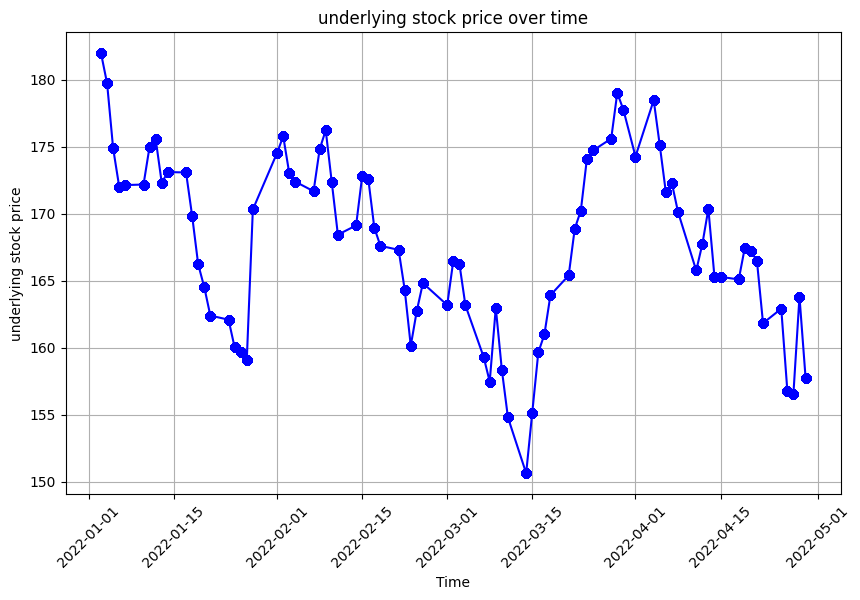

In [33]:
import matplotlib.pyplot as plt

# Plotting the underlying stock price over time
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['underlying_stockprice'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('underlying stock price')
plt.title('underlying stock price over time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


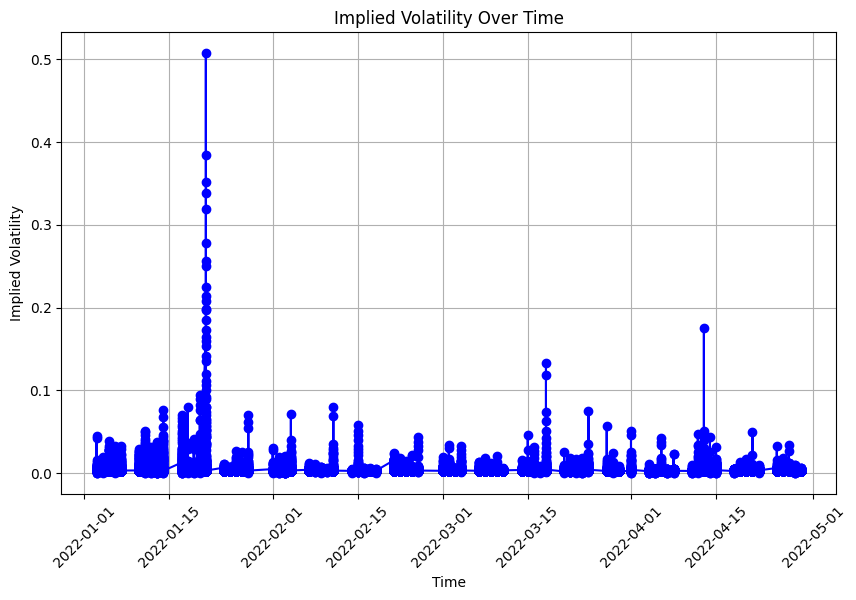

In [34]:
import matplotlib.pyplot as plt

# Plotting the Implied Volatility over time
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['IV'], marker='o', linestyle='-', color='b')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


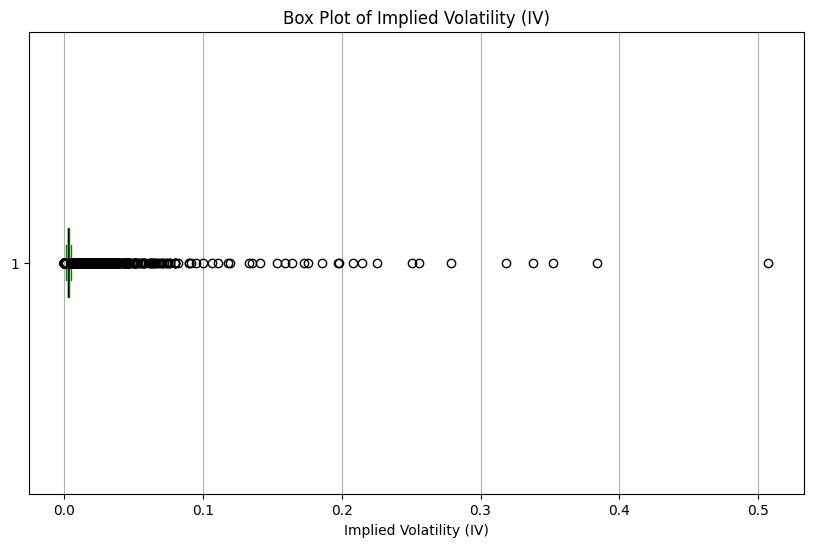

In [35]:
# Plotting a box plot for Implied Volatility (IV) to show its distribution
plt.figure(figsize=(10, 6))
plt.boxplot(data['IV'], vert=False, patch_artist=True, boxprops=dict(facecolor='g', color='g'), whiskerprops=dict(color='g'), capprops=dict(color='g'), medianprops=dict(color='black'))
plt.xlabel('Implied Volatility (IV)')
plt.title('Box Plot of Implied Volatility (IV)')
plt.grid(True, axis='x')
plt.show()


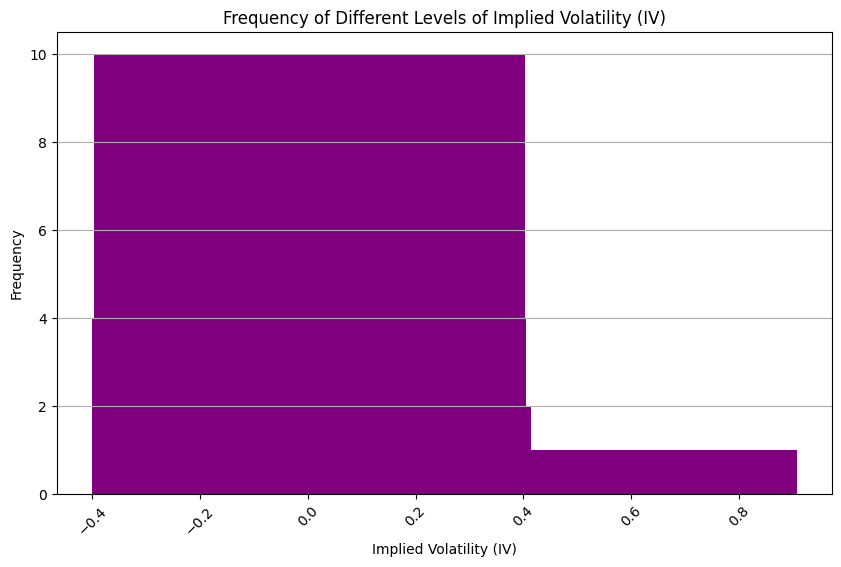

In [36]:
# Plotting a bar chart to show the frequency of different levels of Implied Volatility (IV)
plt.figure(figsize=(10, 6))
iv_counts = data['IV'].value_counts().sort_index()
plt.bar(iv_counts.index, iv_counts.values, color='purple')
plt.xlabel('Implied Volatility (IV)')
plt.ylabel('Frequency')
plt.title('Frequency of Different Levels of Implied Volatility (IV)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


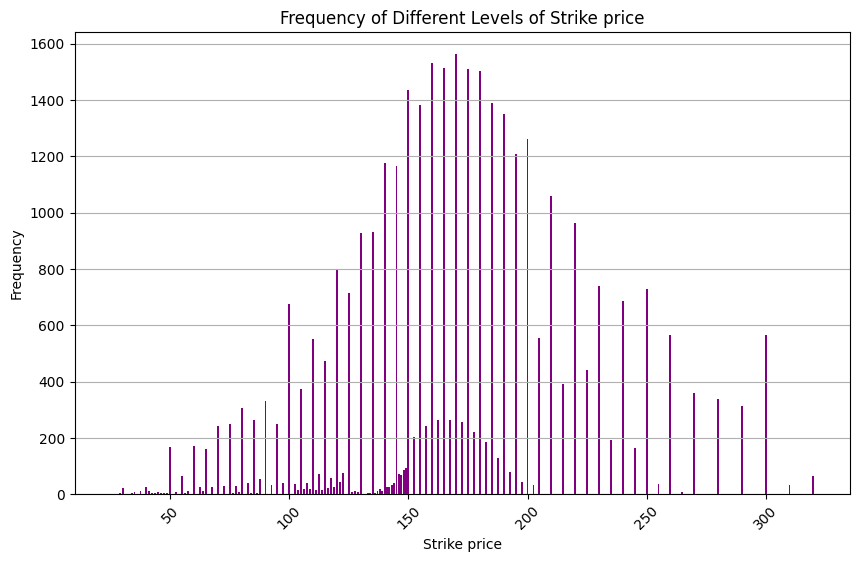

In [37]:
# Plotting a bar chart to show the frequency of different levels of Strike price
plt.figure(figsize=(10, 6))
strike_counts = data['Strike'].value_counts().sort_index()
plt.bar(strike_counts.index, strike_counts.values, color='purple')
plt.xlabel('Strike price')
plt.ylabel('Frequency')
plt.title('Frequency of Different Levels of Strike price')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


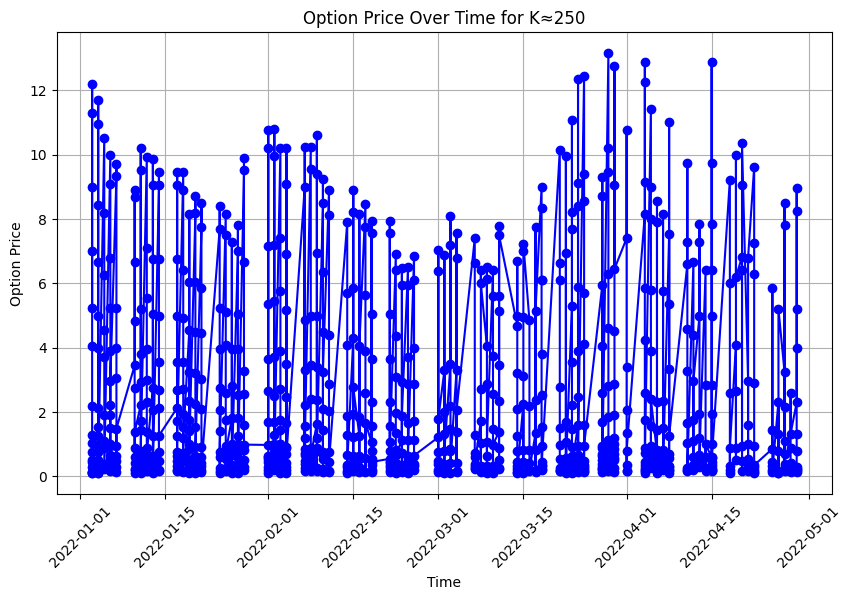

In [38]:
# Plotting Option Price Over Time for a specific strike price (K=250)
# Filter data for strike price closest to 250
if 'Strike' in data.columns:
    # Find strike prices close to 250
    strike_250_data = data[data['Strike'].between(245, 255)].copy()
    
    if len(strike_250_data) > 0:
        # Sort by Time for proper plotting
        strike_250_data = strike_250_data.sort_values(by='Time')
        
        plt.figure(figsize=(10, 6))
        plt.plot(strike_250_data['Time'], strike_250_data['option_price'], marker='o', linestyle='-', color='b')
        plt.xlabel('Time')
        plt.ylabel('Option Price')
        plt.title('Option Price Over Time for K≈250')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
    else:
        print("No data found for strike prices around 250")
else:
    print("Strike column not found in data")
